In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "ct-hypo_DMRs.09.26.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_4090713/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,CN_VIP_GABA,1.893590e-07,1.113317e-07,0.044485,Wuttke.NatGenet.2019.Chronic_kidney_disease_,1.351785
1,Oligodendrocyte,2.115620e-08,1.601307e-08,0.093220,Wuttke.NatGenet.2019.Chronic_kidney_disease_,1.030490
2,STR_SST-CHODL_GABA,2.776320e-07,2.315828e-07,0.115294,Wuttke.NatGenet.2019.Chronic_kidney_disease_,0.938193
3,F_Glut,1.607105e-07,1.500574e-07,0.142086,Wuttke.NatGenet.2019.Chronic_kidney_disease_,0.847448
4,SMC,2.041627e-07,1.949719e-07,0.147518,Wuttke.NatGenet.2019.Chronic_kidney_disease_,0.831156


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

899     0.195869
1333    0.195869
3038    0.195869
2511    0.195869
837     0.376021
          ...   
1258    1.000000
1259    1.000000
1260    1.000000
1248    1.000000
3750    1.000000
Name: FDR_BH_corrected, Length: 3751, dtype: float64


In [9]:
print(adj_pval.sort_values())

2511    0.195869
3038    0.231829
1333    0.250330
899     0.293154
1364    0.376021
          ...   
1365    1.589620
2016    1.597252
838     1.598230
3007    1.608628
1767    1.612064
Name: adj_pval, Length: 3751, dtype: float64


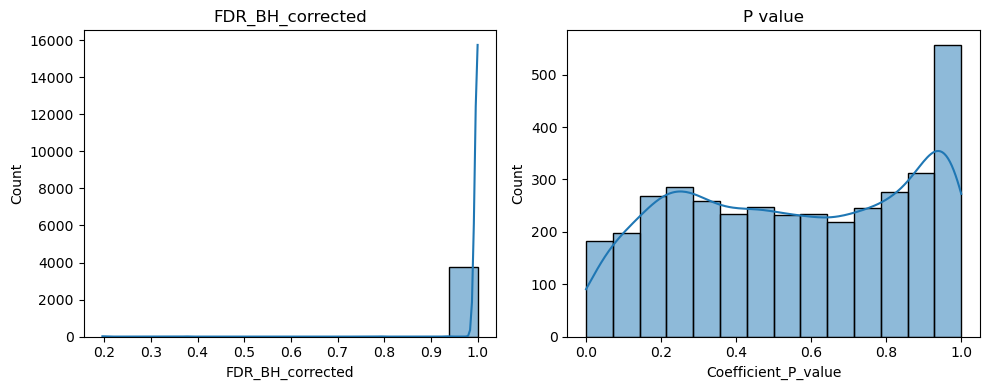

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.000069,0.353252,0.019547,0.298469,0.016339,1.053663e+00,0.283378,0.609353,0.324053,0.014090,...,0.613385,0.379248,1.031715,0.296394,0.321082,0.568709,0.153058,0.017491,0.441033,0.317944
Astrocyte,0.026256,0.179332,0.720792,0.333834,0.003321,1.145075e-01,0.691720,0.553777,0.166081,0.004351,...,1.213590,0.473420,0.205971,0.302356,0.110084,0.001955,0.595803,0.459664,0.883238,0.178834
CN_Cholinergic_GABA,0.001497,0.017858,0.039679,0.011039,0.002536,2.583454e-07,1.585314,0.395230,0.533618,1.178215,...,0.488934,0.003905,0.017658,0.036846,0.057657,0.118604,0.275581,0.590871,0.683037,0.001246
CN_GABA-Glut,0.437344,0.009786,0.204622,0.002434,0.086706,2.030520e-03,0.039358,0.499036,0.108327,0.048324,...,0.227998,0.000764,0.345971,0.130948,0.275461,0.145838,0.399143,0.660615,0.299167,0.454190
CN_LAMP5-CXCL14_GABA,0.044377,0.563727,0.101558,0.489166,0.695160,2.033447e-01,0.076823,0.552174,0.532234,0.095149,...,0.821741,0.376619,0.748121,0.047441,0.134979,0.694061,0.260501,0.050712,0.473753,0.998018


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Astrocyte,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CN_Cholinergic_GABA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CN_GABA-Glut,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CN_LAMP5-CXCL14_GABA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


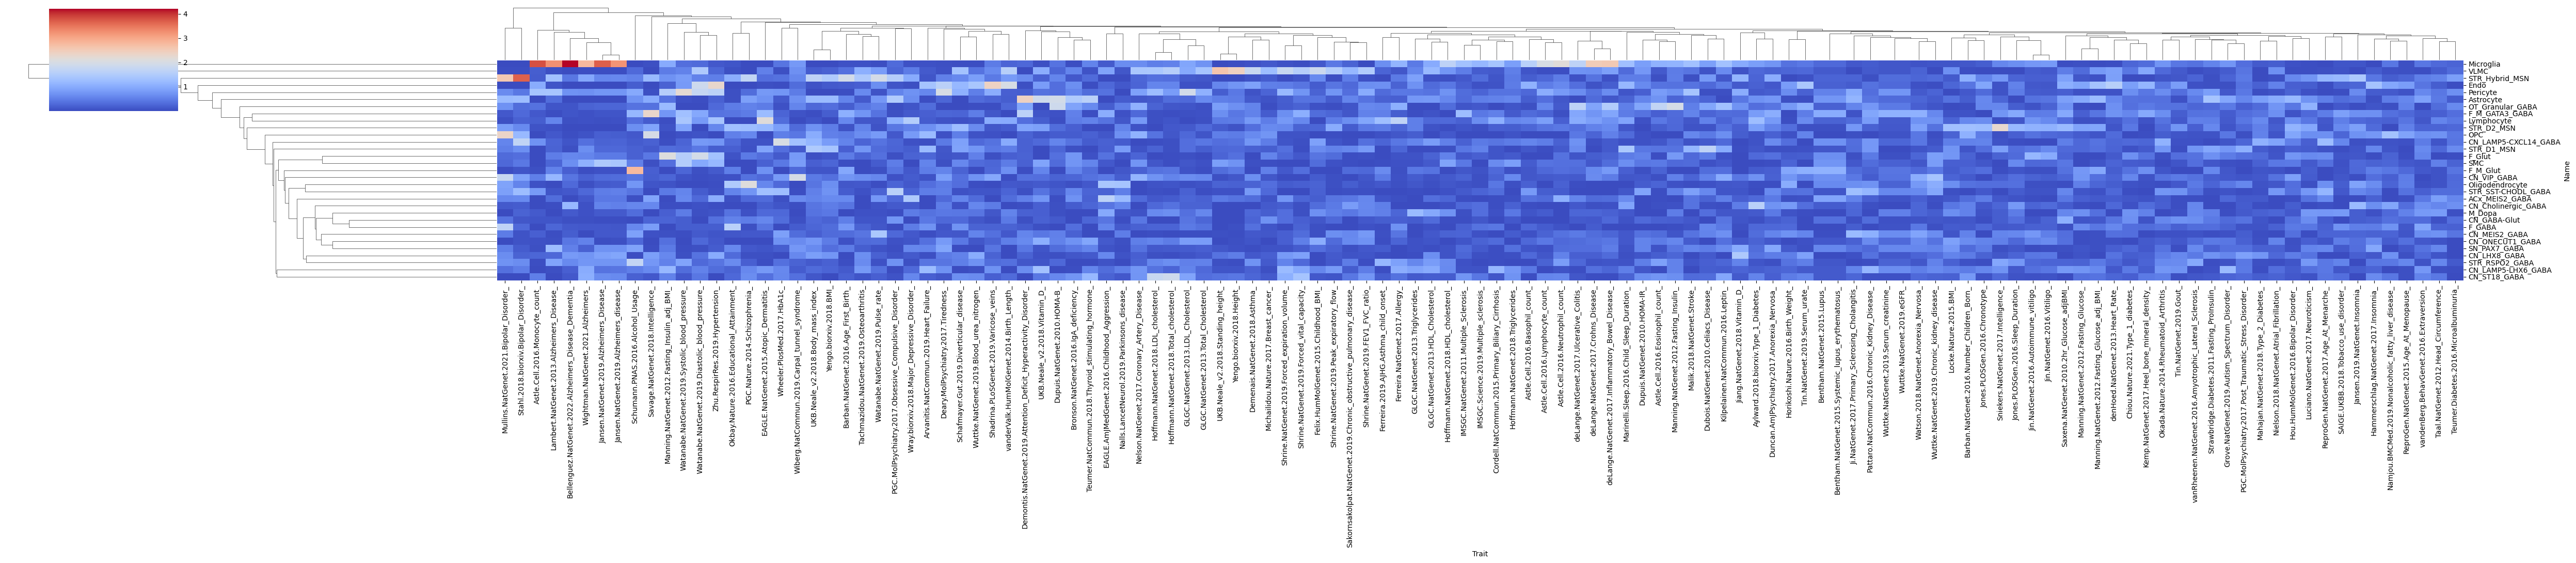

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

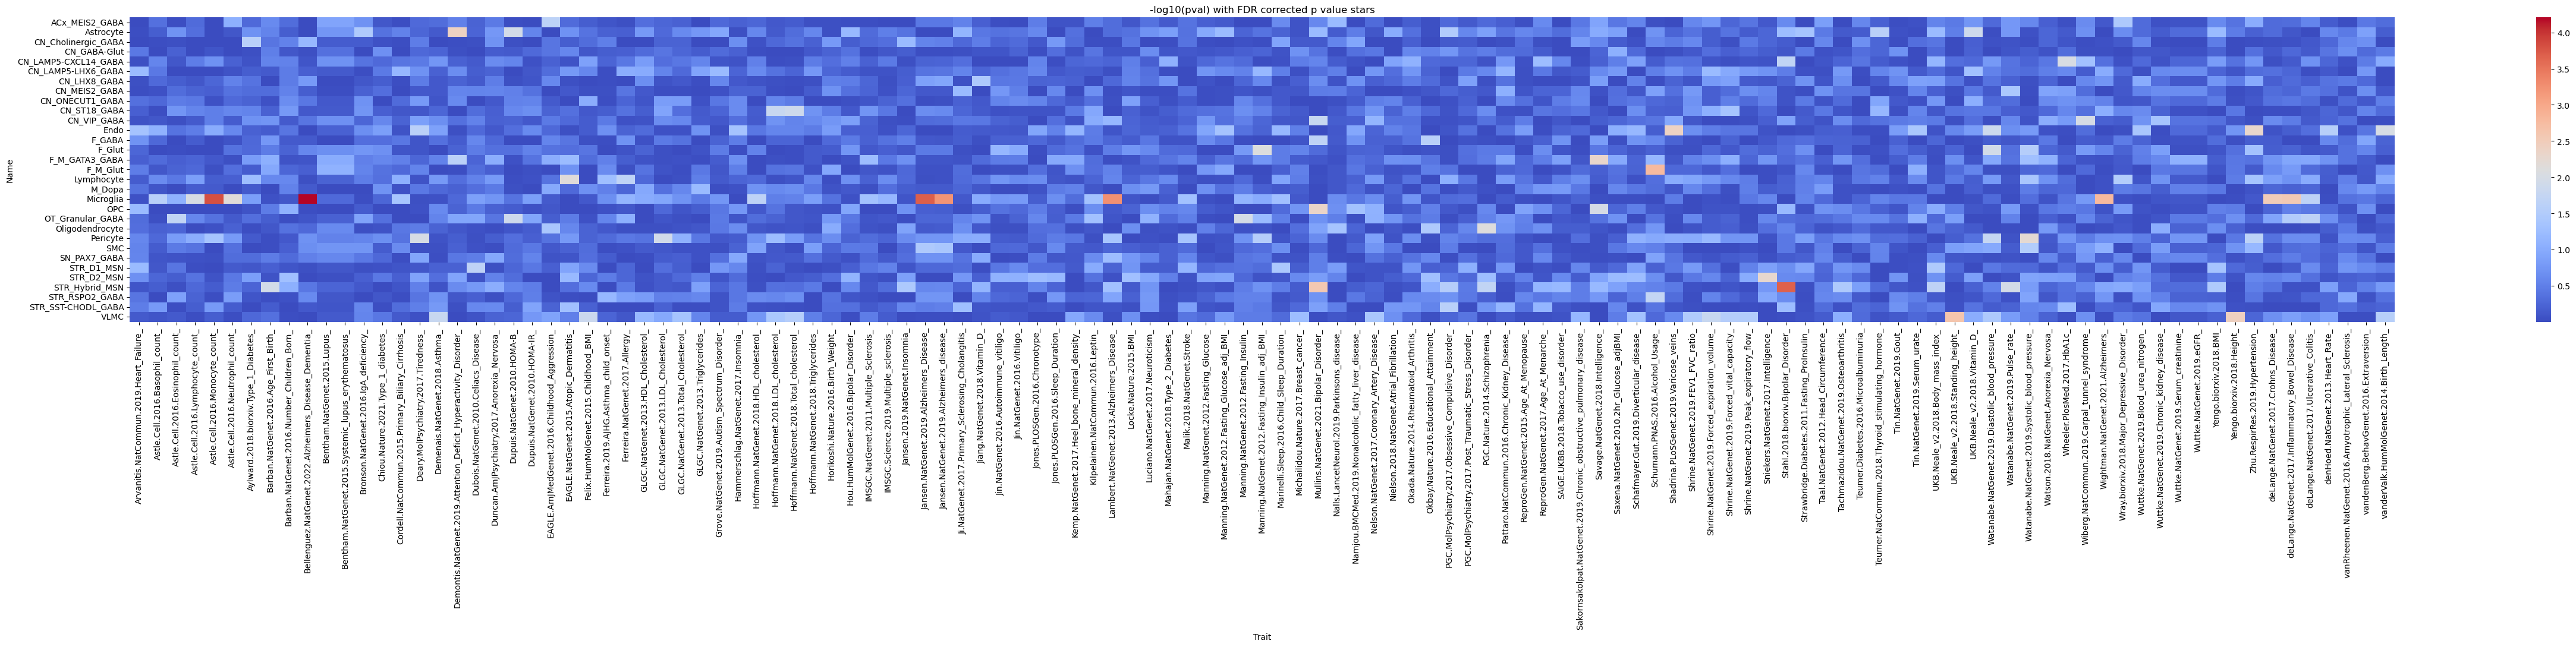

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

